In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
import itertools
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from mutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from mutspec.io import read_genbank_ref
from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Read data

### Verterbata

In [12]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print(mutspec.shape, mutspec.shape[0] / 192)
mutspec.head()

(187008, 10) 974.0


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Cancer

In [177]:
cancer_ms = pd.read_csv("../data/external/cancer_mutspec.csv")[["Mut", "MutSpec_ExDloop"]].rename(columns={"MutSpec_ExDloop": "MutSpec"})
cancer_ms

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273
...,...,...
187,T[T>C]T,0.000471
188,T[T>G]A,0.000133
189,T[T>G]C,0.000000
190,T[T>G]G,0.001074


## Number of observed mutations

In [13]:
mutspec["IsObserved"] = mutspec["Observed"] != 0

In [90]:
mcounts = mutspec.groupby("Mut").IsObserved.value_counts().rename("Count").reset_index().pivot('Mut','IsObserved', "Count").fillna(0).sort_values(False)
mcounts[False] = mcounts[False].astype("int")
mcounts[True] = mcounts[True].astype("int")
mcounts

IsObserved,False,True
Mut,,
G[A>G]A,261,713
G[G>A]A,262,712
T[G>A]A,278,696
A[A>G]G,280,694
T[A>G]T,282,692
...,...,...
A[C>A]T,974,0
A[A>T]T,974,0
A[A>C]T,974,0


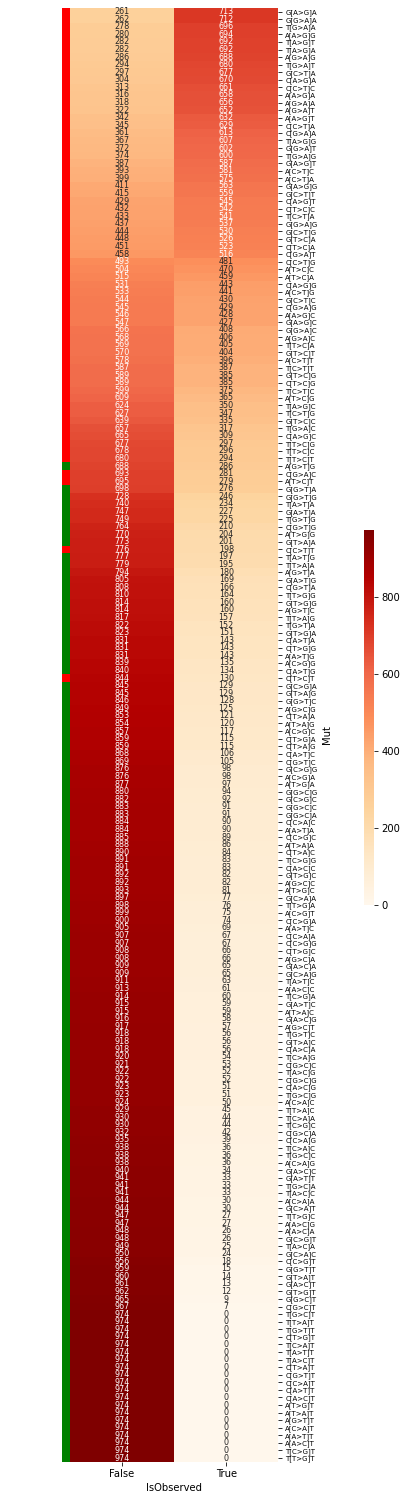

In [91]:
grd = sns.clustermap(
    data=mcounts, 
    cmap="OrRd",
    figsize=(5, 26),
    col_cluster=False, row_cluster=False,
    cbar_pos=(1.02, .32, .03, .2),
    yticklabels=mcounts.index,
    annot=True,
    fmt=".0f",
    annot_kws={'fontsize': 8},
    row_colors=pd.Series(mcounts.index).apply(lambda x: "red" if x[2:5] in ['A>G', 'C>T', 'G>A', 'T>C'] else "green").values
)
plt.setp(grd.ax_heatmap.get_yticklabels(), size=7,)
grd.ax_col_dendrogram.remove()
grd.savefig("../pictures/sbs_counts.pdf")

## Jackknife

In [175]:
def get_class_mutspec(df: Union[pd.DataFrame, str]):
    if isinstance(df, str) and df == "cancer":
        return cancer_ms
    ms = df.groupby("Mut")["RawMutSpec"].sum().reset_index().rename(columns={"RawMutSpec": "MutSpec"})
    ms["MutSpec"] = (ms["MutSpec"] / ms["MutSpec"].sum()).fillna(0)
    return ms


def sample_sp_ms(df: pd.DataFrame, ntimes=100):
    sp = df.Species.unique()
    df = df.set_index("Species")
    n = len(sp)
    for _ in range(ntimes):
        smpl = np.random.choice(sp, n)
        mut = df.loc[smpl]
        yield mut


def dummy_sampler(ntimes=100):
    for _ in range(ntimes):
        yield "cancer"

In [178]:
classes = list(mutspec["Class"].unique()) + ["cancer"]
ntimes = 100
data = []
for cls1, cls2 in itertools.combinations(classes, 2):
    if cls1 == "cancer":
        muts1 = dummy_sampler(ntimes)
    else:
        muts1 = sample_sp_ms(mutspec[(mutspec.Class == cls1)], ntimes)
    if cls2 == "cancer":
        muts2 = dummy_sampler(ntimes)
    else:
        muts2 = sample_sp_ms(mutspec[(mutspec.Class == cls2)], ntimes)
    for i in range(ntimes):
        gr1, gr2 = next(muts1), next(muts2)
        ms1, ms2 = get_class_mutspec(gr1), get_class_mutspec(gr2)
        sim = 1 - spatial.distance.cosine(ms1.sort_values("Mut").MutSpec.values, ms2.sort_values("Mut").MutSpec.values)
        data.append({
            "cls1": cls1,
            "cls2": cls2,
            "DroppedSBS": "none",
            "CosSim": sim,
        })
        for sbs_to_drop in mutspec.Mut.unique():
            ms1drp, ms2drp = ms1[ms1.Mut != sbs_to_drop], ms2[ms2.Mut != sbs_to_drop]
            sim = 1 - spatial.distance.cosine(ms1drp.sort_values("Mut").MutSpec.values, ms2drp.sort_values("Mut").MutSpec.values)
            data.append({
                "cls1": cls1,
                "cls2": cls2,
                "DroppedSBS": sbs_to_drop,
                "CosSim": sim,
            })

In [191]:
dif = pd.DataFrame(data)
# dif.to_csv("../data/dif.csv", index=None)
dif

,cls1,cls2,DroppedSBS,CosSim
0,Actinopterygii,Mammalia,none,0.935247
1,Actinopterygii,Mammalia,T[T>G]T,0.935247
2,Actinopterygii,Mammalia,G[T>G]T,0.935247
3,Actinopterygii,Mammalia,C[T>G]T,0.935247
4,Actinopterygii,Mammalia,A[T>G]T,0.935247
...,...,...,...,...
289495,Amphibia,cancer,A[A>G]A,0.774055
289496,Amphibia,cancer,T[A>C]A,0.774105
289497,Amphibia,cancer,G[A>C]A,0.774103
289498,Amphibia,cancer,C[A>C]A,0.774141


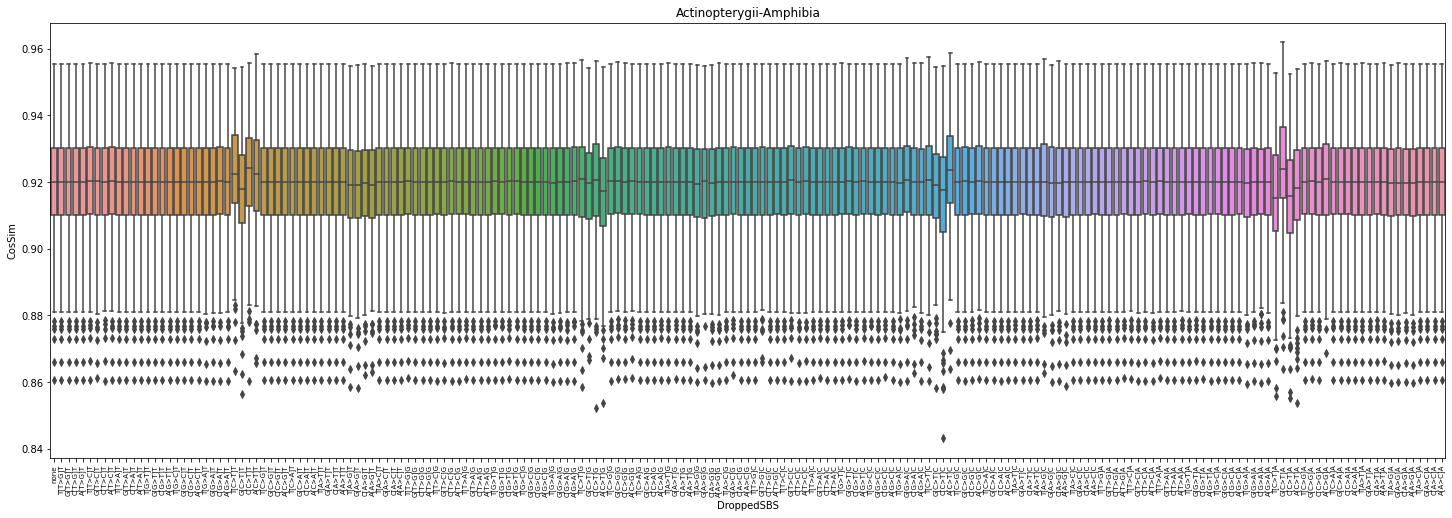

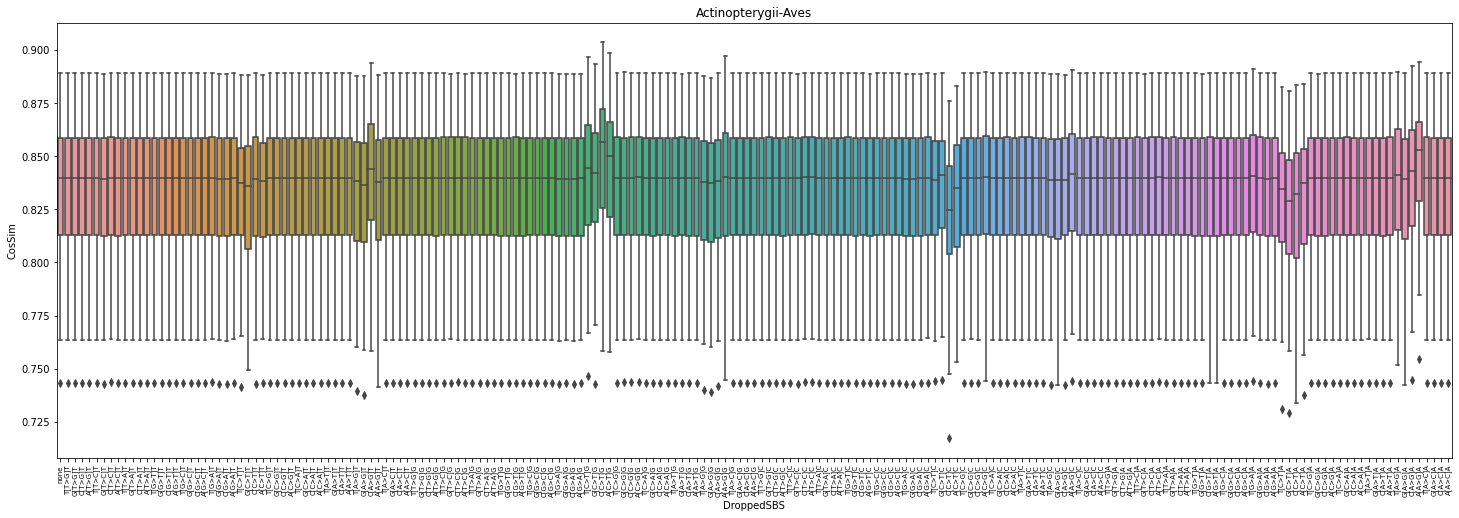

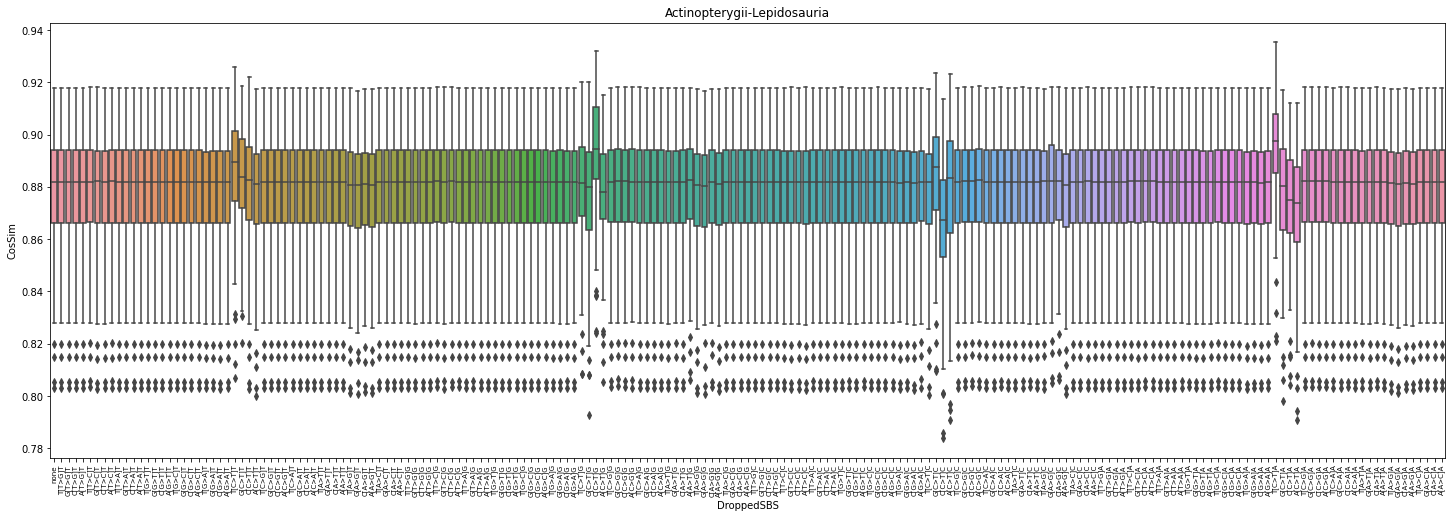

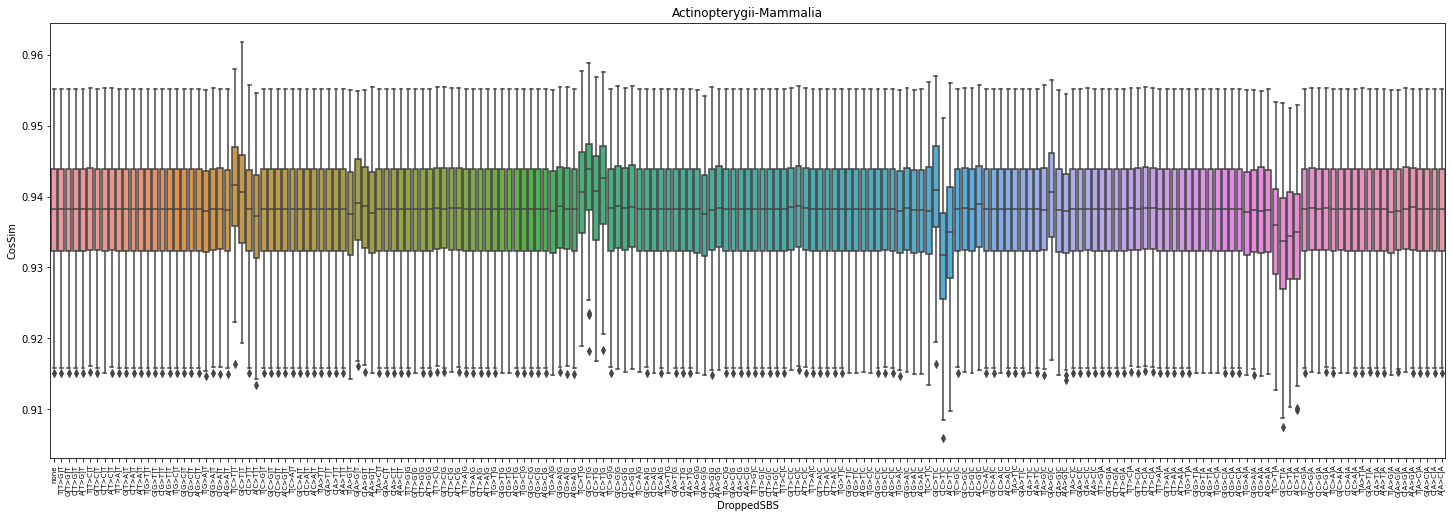

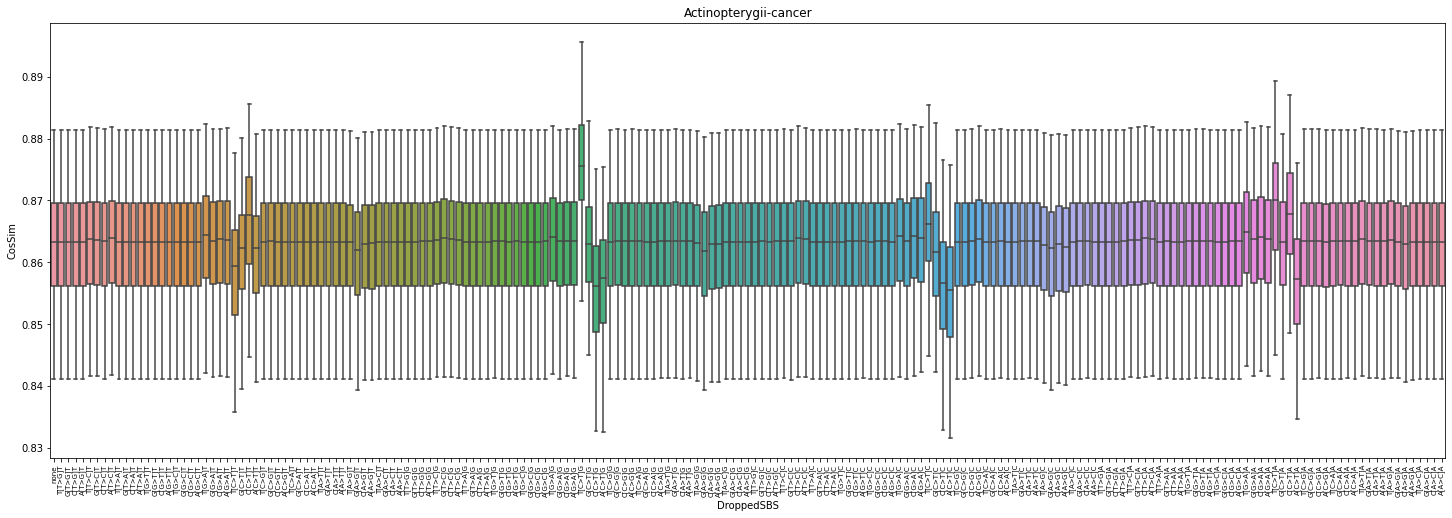

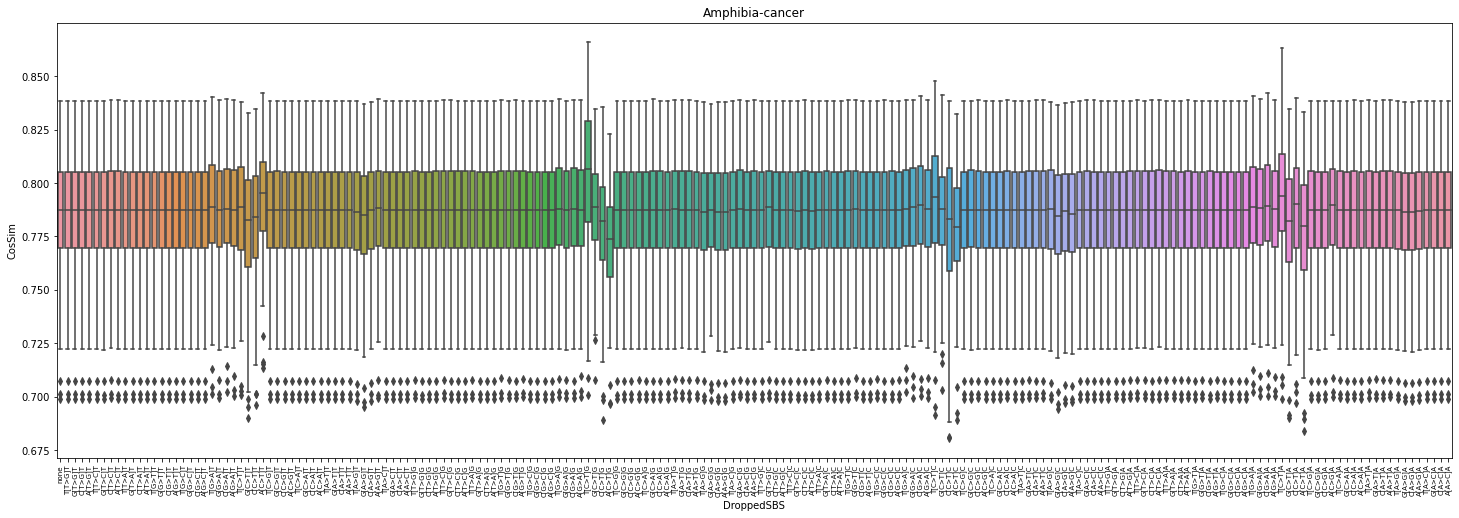

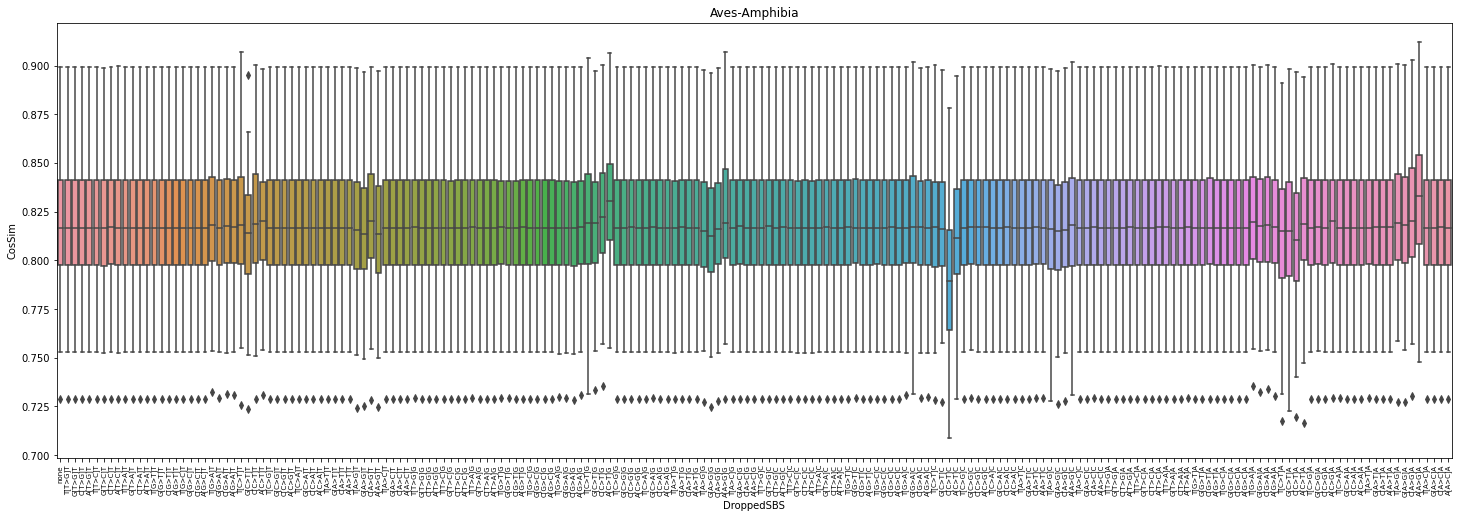

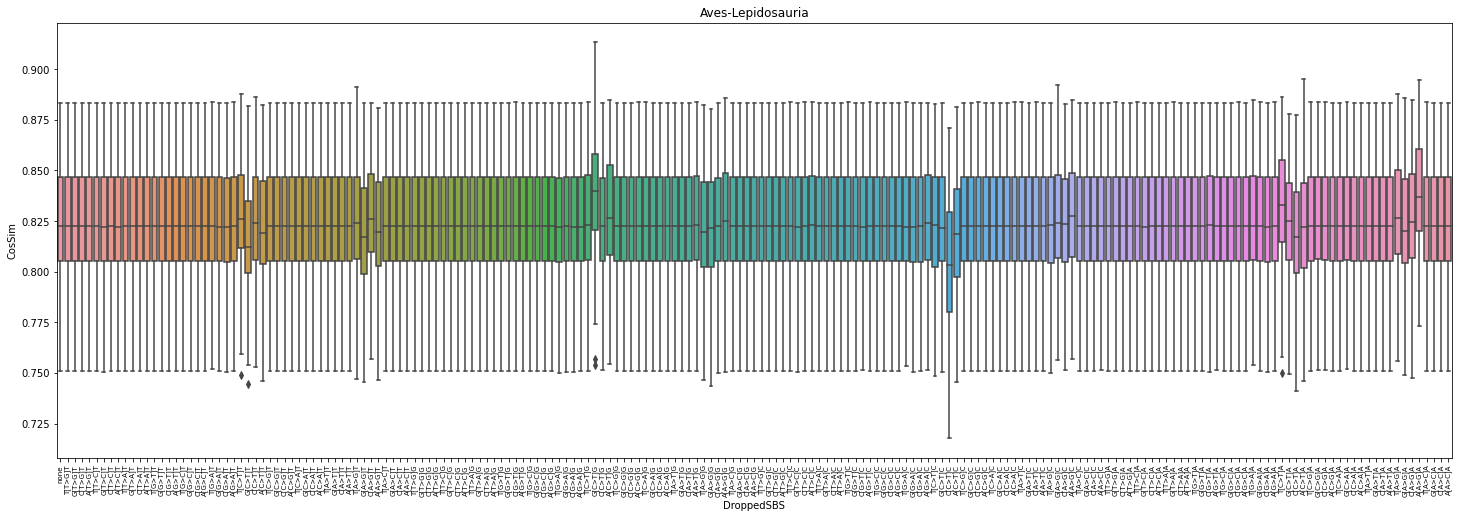

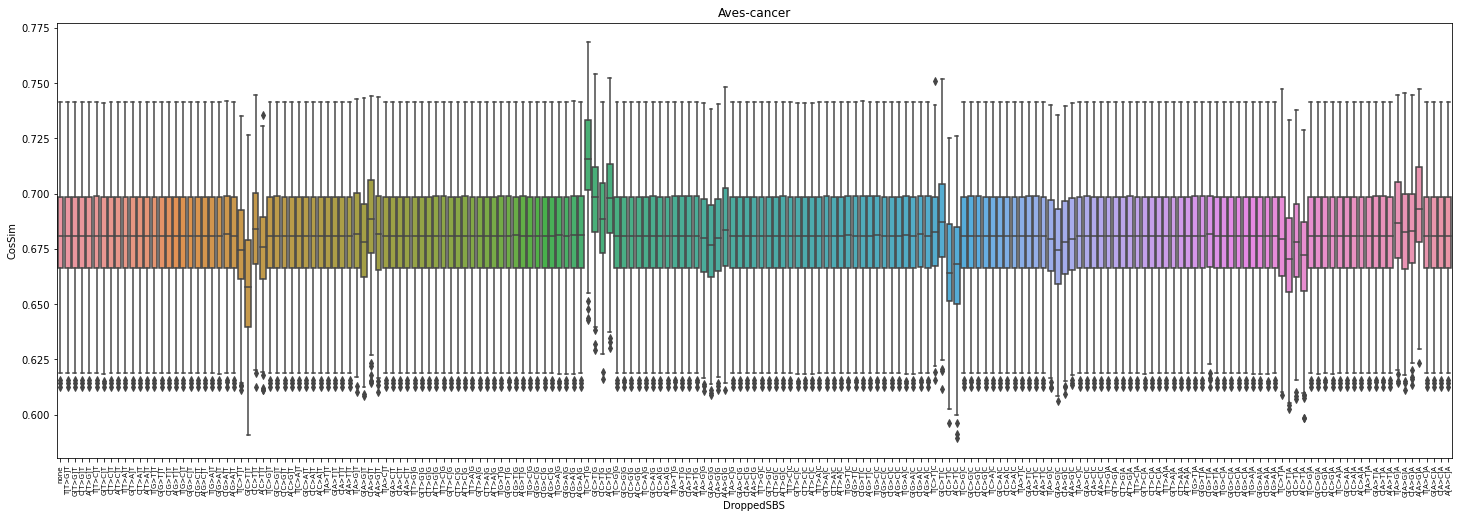

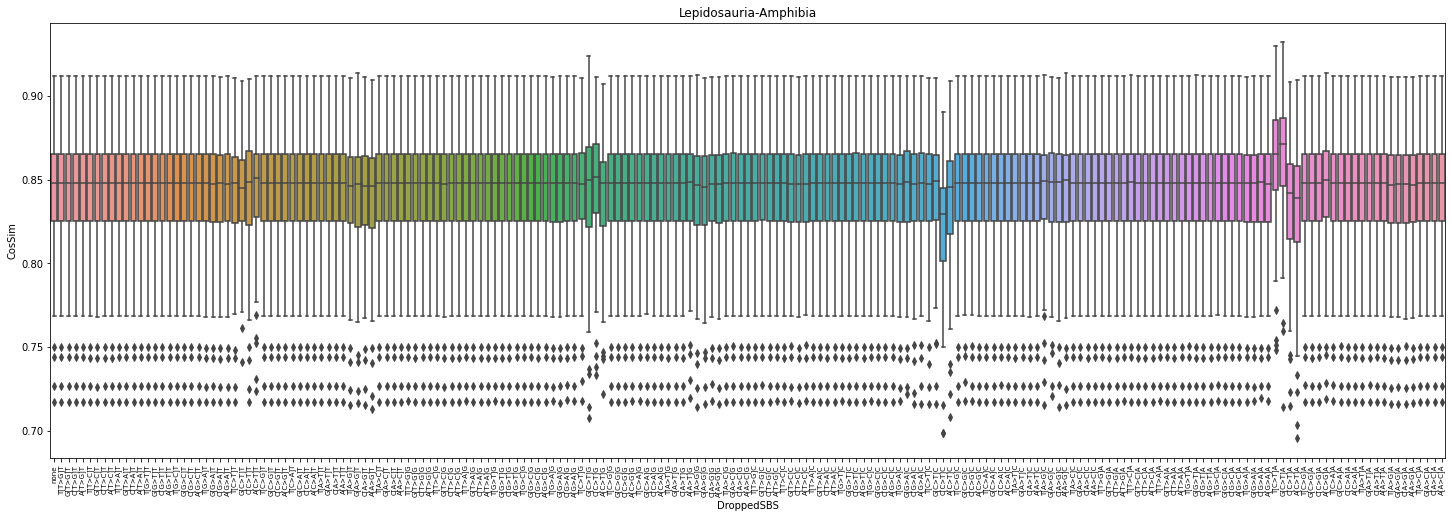

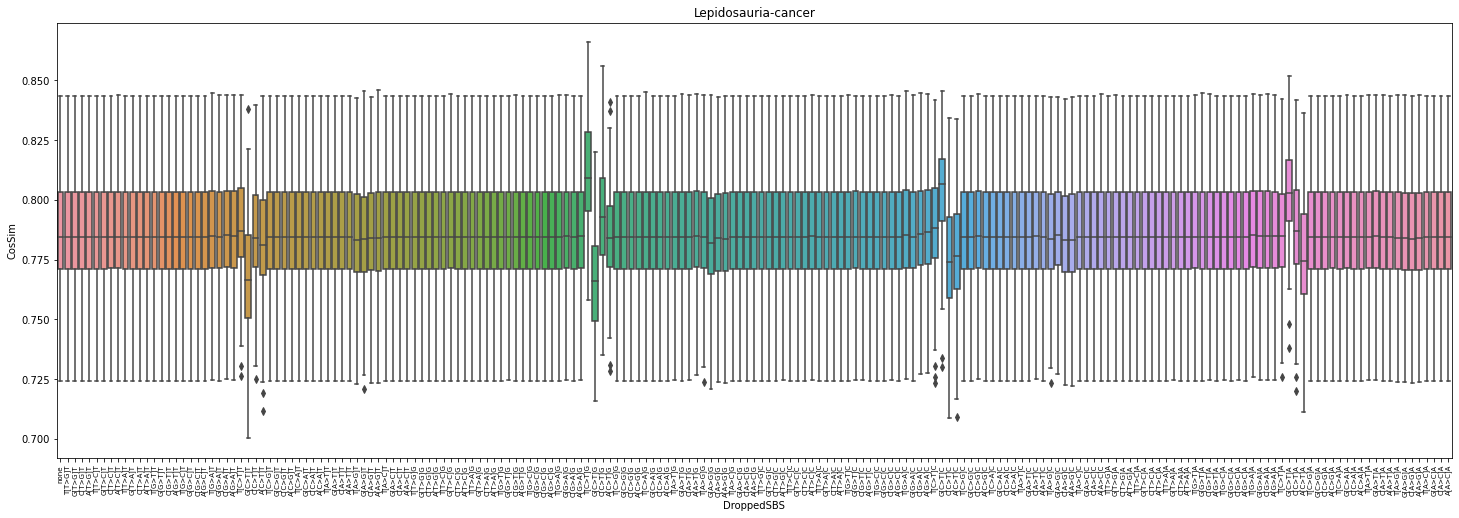

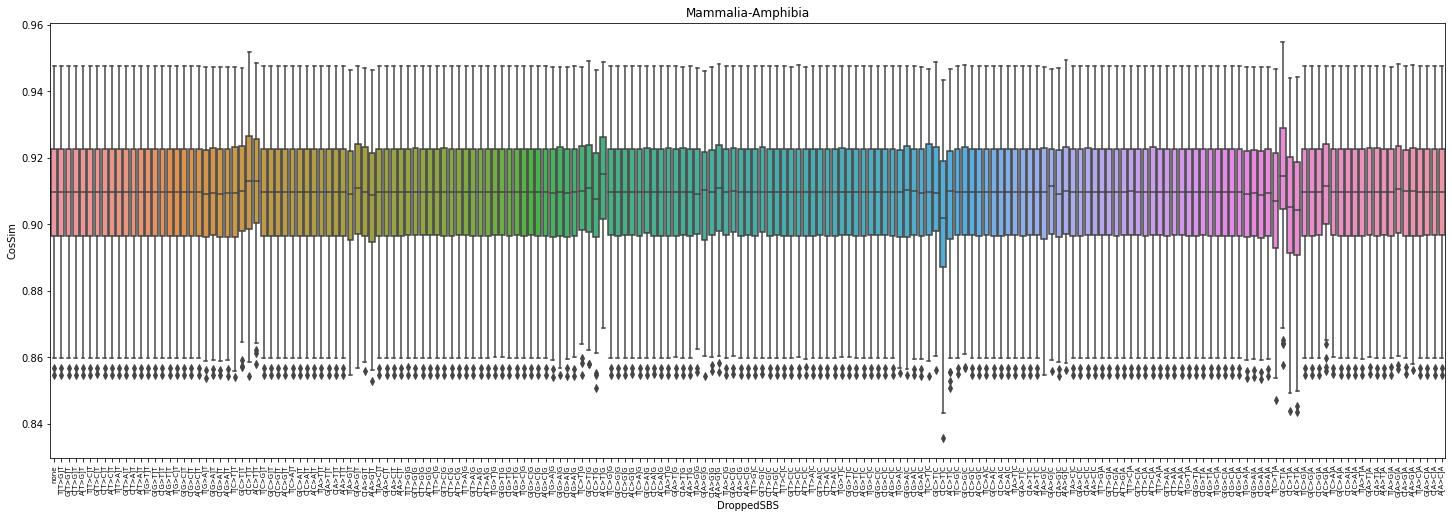

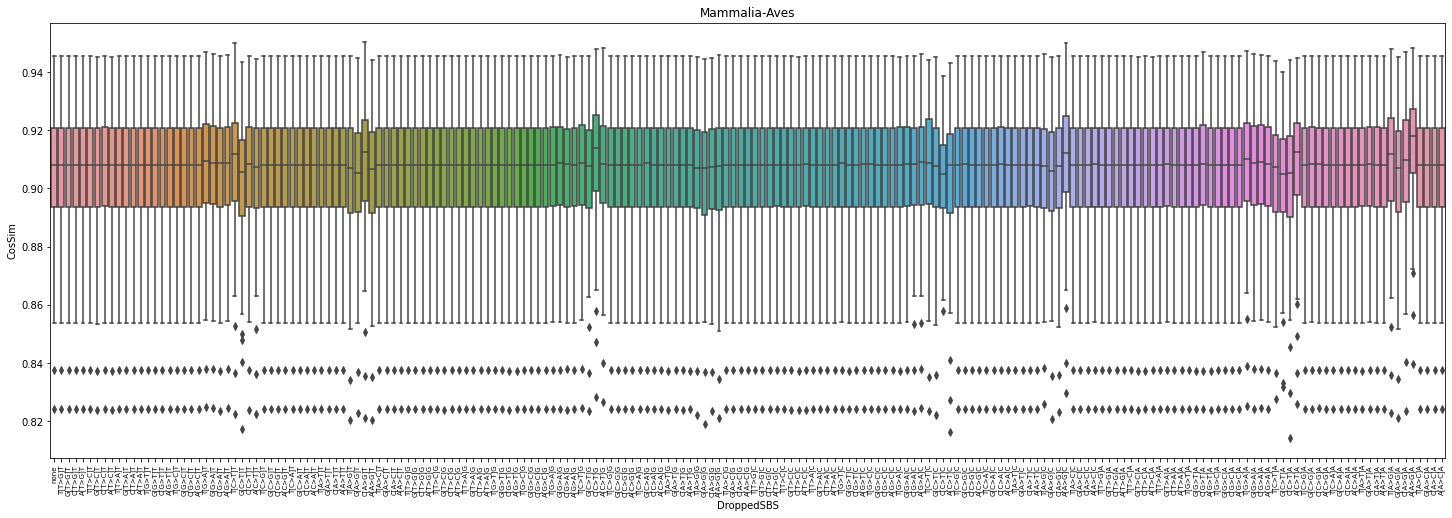

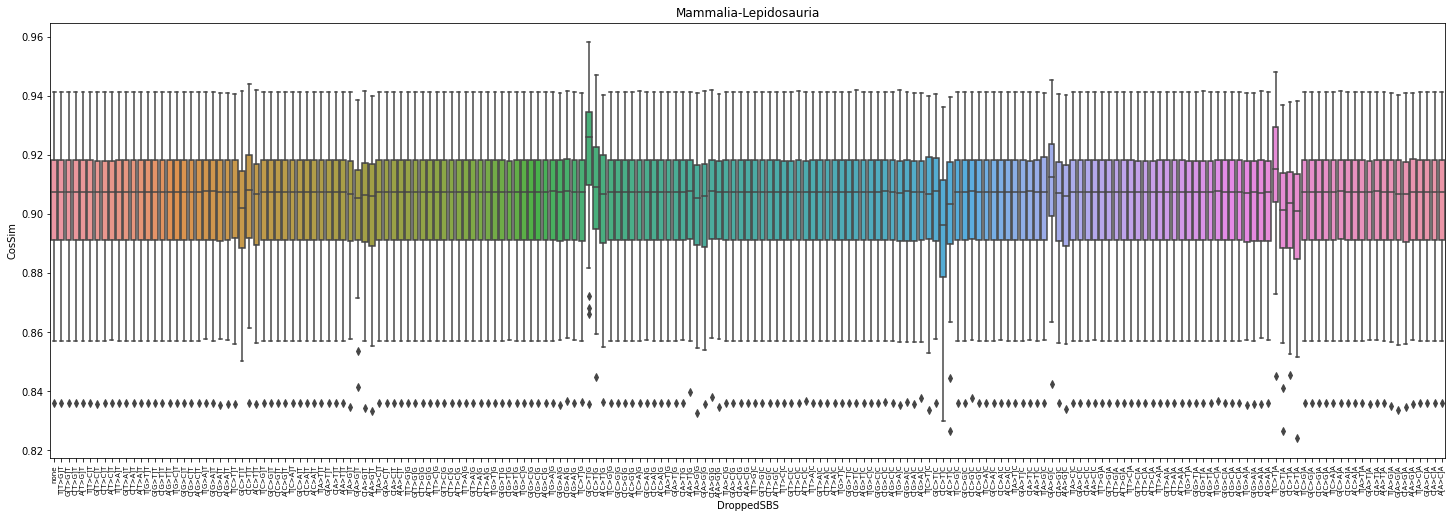

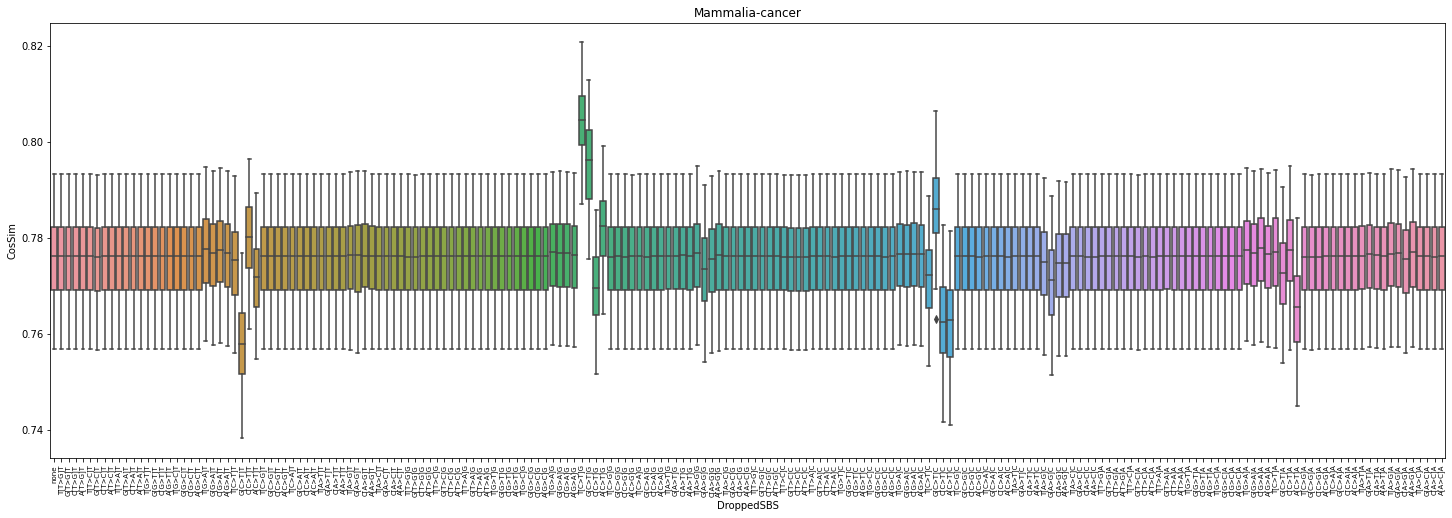

In [195]:
for lbl, gr in dif.groupby(["cls1", "cls2"]):
    plt.figure(figsize=(25, 8))
    plt.title("-".join(lbl))
    sns.boxplot(data=gr, x="DroppedSBS", y="CosSim")
    plt.xticks(rotation=90, fontsize=7)
    plt.show()